# Imports

In [1]:
%matplotlib ipympl

In [2]:
import numpy as np
import math
import scipy
import py3nj
import pandas as pd
import matplotlib.pyplot as plt

# Hamiltonian Matrix Representation

In this notebook we will examine the rotational energy levels of a diatomic molecule, caused by fine structure and external magnetic field. We will use the coupled basis $\ket{JIFm_F}$, where $J$ is the rotational quantum number, $I$ is the total nuclear spin (of each nucleus), $F = J + I$ and $m_F$ is the projection of F onto the z-axis. We will take the external B-field in the z-axis. The full hamiltonian takes the form:

$H = H_{IZ} + H_{JZ} + H_{IJ} + H_{dip} + H_{diam}$

We will ignore the diamagnetic term as the book *Rotational Spectroscopy of Diatomic Molecules* ignores it, and that is the book this model comes from. 

In the following code we find the matrix elements $H_{xy} = \braket{JIFm_F||JIF'm_F'}$, and then diagonalize the resulting matrix to get energies. We repeat this for different magnetic field values.

In [3]:
def neg_1_to_x(x):
    return 1 - 2 * (x % 2)

In [4]:
def count_basis(J,I):
    F_max = I+J
    F_min = abs(I-J)
    
    F_range = np.arange(F_min,F_max+1,J)
    dim = len(F_range)*len(F_range)
    
    basis = [(0,0) for elem in range(dim)]
    
    ct = 0
    for elem in F_range:
        m_F = -1*elem
        while m_F <= elem:
            basis[ct] = (elem,m_F)
            ct+=1
            m_F += 1
    
    return F_range, basis[::-1]

In [5]:
count_basis(1,1)

(array([0, 1, 2]),
 [(2, 2), (2, 1), (2, 0), (2, -1), (2, -2), (1, 1), (1, 0), (1, -1), (0, 0)])

In [6]:
def get_H_xy_B_field(index1,
                     index2,
                     J,
                     I,
                     Bz,
                     a=4.258,           # kHz
                     b=0.6717,          # kHz
                     c=-113.904,        # kHz
                     d=57.671,          # kHz       
                     gH=2.002319,       # dimensionless
                     muN=7622.59321,    # kHz / Tesla
                     sigmaHJ=0,         # unknown screening factor; will ignore for now 
                     I_1=0.5,           # Taking a guess on these; spin of each nuclei?
                     I_2=0.5):
    
    # finding the values of F and mF for each index
    basis = count_basis(J,I)[1]
    F_1, mF_1 = basis[index1]
    F_2, mF_2 = basis[index2]
    
    deltaF = 0
    if F_1 == F_2:
        deltaF = 1
    
    deltaM = 0
    if mF_1 == mF_2:
        deltaM = 1
    
    # initialiazing hamiltonian matrix element
    H_xy = 0
    
    #print("(F, mF)", F_1, mF_1)
    #print("(F', mF')",F_2, mF_2)
    
    # computing nuclear spin zeeman term
    H_IZ = 0
    if deltaM == 1:
        wig_part = py3nj.wigner3j(2*F_1, 2, 2*F_2, -2*mF_1, 0, 2*mF_1) * py3nj.wigner6j(2*I, 2*F_2, 2*J, 2*F_1, 2*I, 2) 
        H_IZ = -gH*muN*Bz*(1-sigmaHJ)*neg_1_to_x(F_1-mF_1)*neg_1_to_x(F_1+J+I+1)*math.sqrt((2*F_1+1)*(2*F_2+1)*I*(I+1)*(2*I+1))*wig_part
    #print("H_IZ", H_IZ)
    
    # computing rotational zeeman term
    H_JZ = 0
    if deltaM == 1:
        wig_part = py3nj.wigner3j(2*F_1, 2, 2*F_2, -2*mF_1, 0, 2*mF_1) * py3nj.wigner6j(2*J, 2*F_2, 2*I, 2*F_1, 2*J, 2) 
        H_JZ = -gH*muN*Bz*(1-sigmaHJ)*neg_1_to_x(F_1-mF_1)*neg_1_to_x(F_2+J+I+1)*math.sqrt((2*F_1+1)*(2*F_2+1)*J*(J+1)*(2*J+1))*wig_part
    #print("H_JZ", H_JZ)
    
    # computing nuclear rotation term
    H_IJ = 0
    if deltaM == 1 and deltaF == 1:
        wig_part = py3nj.wigner6j(2*I, 2*J, 2*F_1, 2*J, 2*I, 2)
        H_IJ = c*neg_1_to_x(J+F_1+I)*math.sqrt(J*(J+1)*(2*J+1)*I*(I+1)*(2*I+1))*wig_part
    #print("H_IJ", H_IJ)
    
    # computing nuclear spin dipole term
    H_dip = 0
    if deltaM == 1 and deltaF == 1:
        wig_part = py3nj.wigner6j(2*I, 2*J, 2*F_1, 2*J, 2*I, 4) * py3nj.wigner9j(int(2*I_1), int(2*I_1), 2, int(2*I_2), int(2*I_2), 2, 2*I, 2*I, 4)
        H_dip = -30*d*deltaF*deltaM*neg_1_to_x(J+F_1+I)*(2*I+1)*math.sqrt(I_1*(I_1+1)*(2*I_1+1)*I_2*(I_2+1)*(2*I_2+1))*wig_part
        #print("H_dip", H_dip)
    
    H_xy = H_IZ + H_JZ + H_IJ + H_dip
    #print("Total: ", H_xy)
    return H_xy

In [7]:
def find_H(J, I, Bz, dim):
  # B is the rotational constant
  # d is the molecular dipole moment
  # E is the electric field strength
  # m is the projection of angular momentum
  # dim is the dimension of the basis for the hamiltonian

  # Initialize Hamiltonian matrix
  H = np.zeros((dim,dim))

  # Fill Hamiltonian matrix with term by term 
  for i in range(dim):
    for j in range(i,dim):

      FS_term = get_H_xy_B_field(i,
                                j,
                                J,
                                I,
                                Bz)

      if i == j:
        H[i][j] = FS_term
      else:
        H[i][j] = FS_term
        H[j][i] = np.conjugate(FS_term)
  return H

In [8]:
H = find_H(1, 1, 10, 9)

In [9]:
H

array([[-3.05400004e+05,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.52771372e+05,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -1.42739500e+02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.52485893e+05,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  3.05114525e+05,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -1.523705

In [10]:
brange = np.arange(0, 0.1, 0.001)

In [11]:
eigenvalues = []
for B in brange:
    H = find_H(1, 1, B, 9)
    scipy.linalg.eig(H)
    eigenstates = scipy.linalg.eig(H)
    eigenvalues.append(np.sort(eigenstates[0]))

/home/peter/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/peter/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Rotational Energy Levels for H2 in F MF basis')

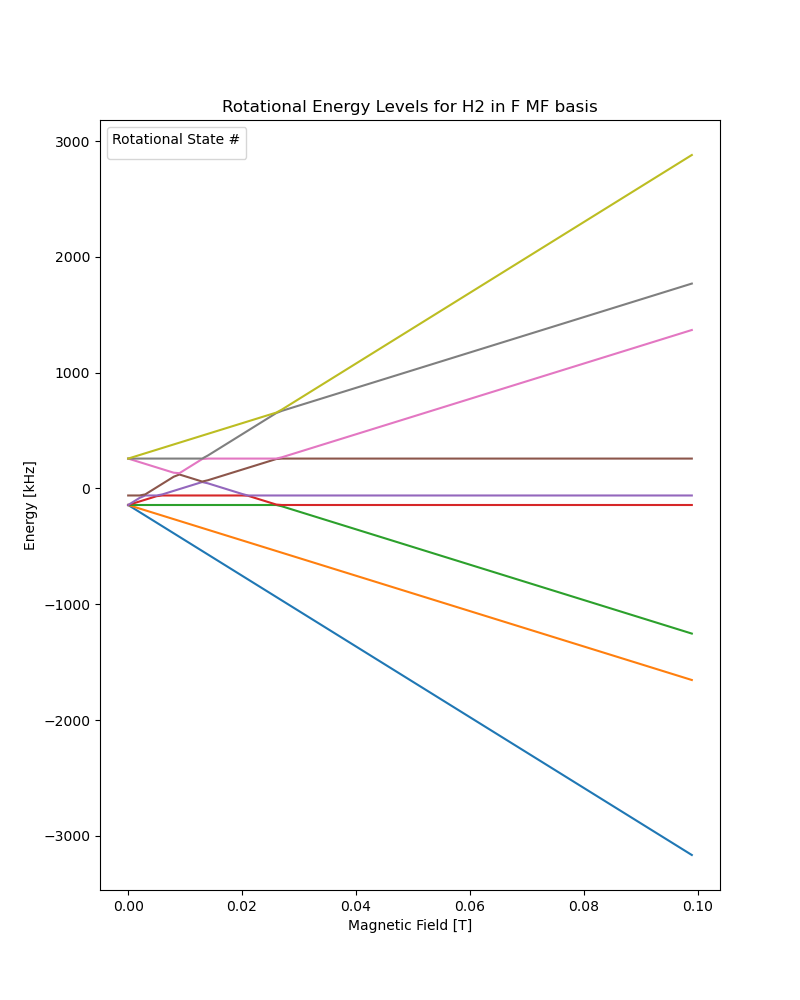

In [12]:
fig, ax = plt.subplots(figsize=(8, 10))
ax.plot(brange, eigenvalues)
ax.set_ylabel("Energy [kHz]")
ax.set_xlabel("Magnetic Field [T]")
ax.legend(title="Rotational State #")
ax.set_title("Rotational Energy Levels for H2 in F MF basis")

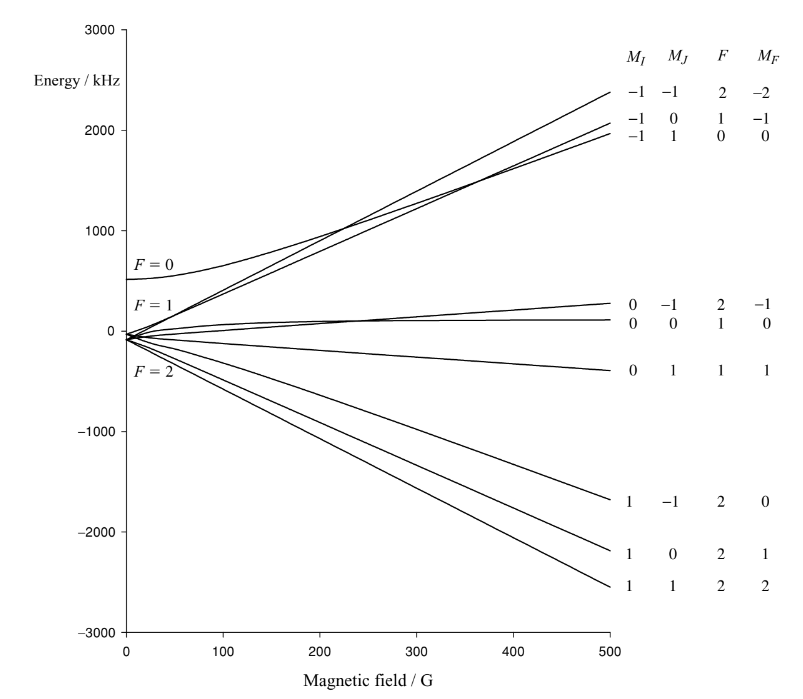